In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from itertools import product
plt.rcParams['figure.figsize'] = [3,4]

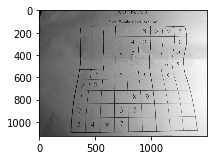

In [3]:
#Import ảnh ban đầu. Resize về rộng 1500, quy về grayscale
image0=cv2.imread('2.jpg')
height,width,_=image0.shape
newH,newW=int(height*1500/width),1500
image0=cv2.resize(image0,(newW,newH))
image=cv2.cvtColor(image0,cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap='gray')

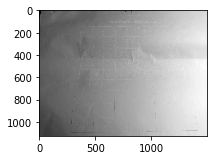

In [4]:
#Remove shadow
dilate=cv2.dilate(image,np.ones((7,7), np.uint8))
plt.imshow(dilate,cmap='gray')

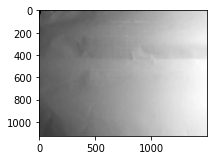

In [5]:
bg_img = cv2.medianBlur(dilate, 21)
plt.imshow(bg_img,cmap='gray')

True

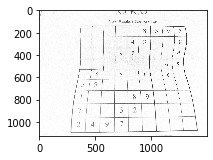

In [6]:
diff_img = 255 - cv2.absdiff(image, bg_img)
plt.imshow(diff_img,cmap='gray')
cv2.imwrite('out1.jpg',diff_img)

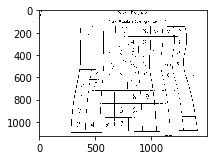

In [7]:
#Thresholding ảnh bằng adaptiveThreshold, hiện tại vẫn để otzu để làm cơ sở thresh cho canny line detection. Không dùng otzu vì dùng otzu sẽ gây mất cạnh với những 
high_thresh,_=cv2.threshold(diff_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img1=cv2.adaptiveThreshold(diff_img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,7)
plt.imshow(img1,cmap='gray')
cv2.imwrite('out11.jpg',img1)
low_thresh=0.5*high_thresh

True

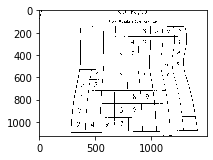

In [8]:
#median blur để bỏ noise
img11=cv2.medianBlur(img1,3)
plt.imshow(img11,cmap='gray')
cv2.imwrite('out111.jpg',img11)

True

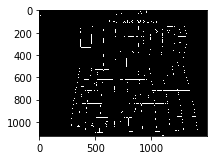

In [9]:
#chuyển thành dạng cạnh bằng Canny, lowthresh và highthresh thông qua otzu ở trên
image3=cv2.Canny(img11,low_thresh,high_thresh)
plt.imshow(image3,cmap='gray')
cv2.imwrite('out12.jpg',image3)

True

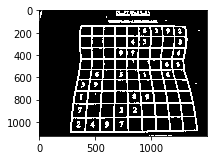

In [10]:
#Dilate -> Opening -> Closing ảnh để bỏ noise, liền cạnh,....
image4 = cv2.dilate(image3,cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)),iterations=3)
plt.imshow(image4,cmap='gray')
cv2.imwrite('out14.jpg',image4)

In [ ]:
#contour 1 cho ô lớn
image8=image0.copy()
image9=image0.copy()
image10=image4.copy()
_,contours,hierachy=cv2.findContours(image4.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
c=[[i,contours[i],cv2.contourArea(contours[i])] for i in range(len(contours))]
maxCon=max(c,key=lambda c:c[2])

core=cv2.moments(maxCon[1])
cX = int(core["m10"] / core["m00"])
cY = int(core["m01"] / core["m00"])
peri=cv2.arcLength(maxCon[1],True)
cnx=cv2.convexHull(maxCon[1],returnPoints=True)
approx=cv2.approxPolyDP(cnx,0.03*peri,True)
min_approx=min([[k,approx[k]] for k in range(4)], key =lambda x:x[1][0][0]+x[1][0][1])
new_approx=approx.copy()
for k in range(4):
    new_approx[k]=approx[(k+min_approx[0])%4]
approx=new_approx

# cv2.drawContours(image9,approx,-1,(0,255,0),5)
# cv2.imwrite('vertice_big.jpg',image9)

after=np.array([[cX-300,cY-300],[cX+300,cY-300],[cX+300,cY+300],[cX-300,cY+300]],dtype="float32")# 4 đỉnh lúc sau. tính từ tâm đổ ra và đổ về 45px. 45px có thể modify tùy theo chu vi hình vuông cho chính xác.
approx=np.array([approx[0][0],approx[1][0],approx[2][0],approx[3][0]],dtype="float32")# 4 đỉnh ban đầu 

for k in range(4):
    if approx[k][0]<cX:
        approx[k][0]-=30
    else:
        approx[k][0]+=30
    if approx[k][1]<cY:
        approx[k][1]-=30
    else:
        approx[k][1]+=30
        
perspect=cv2.getPerspectiveTransform(approx,after)
res0=cv2.warpPerspective(image8,perspect,(newW,newH))
res4=cv2.warpPerspective(image10,perspect,(newW,newH))
res0=res0[cY-300:cY+300,cX-300:cX+300,:]
res4=res4[cY-300:cY+300,cX-300:cX+300]
# cv2.imwrite('piece_big_0.jpg',res0)
# cv2.imwrite('piece_big_4.jpg',res4)

In [85]:
#Tìm contour cho ô nhỏ:
image8=res0.copy()
_,contours,hierachy=cv2.findContours(res4.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
c=[[i,contours[i],cv2.contourArea(contours[i])] for i in range(len(contours))]
maxCon=max(c,key=lambda c:c[2])

#inner: mảng chứa các contour con của maxCon; chính là các ô sudoku con, 81 ô. Lưu ý thứ tự trong đây đang không đúng thứ tự sắp xếp
child=hierachy[0][maxCon[0]][2]
inner=[]
while(child!=-1):
    inner.append(child)
    child=hierachy[0][child][0]
    
#Với từng ô con: tìm 4 đỉnh, tâm, sau đó xoay hình ban đầu để ô con đó về hình vuông
for j in range(len(inner)):
    if cv2.contourArea(contours[inner[j]])>maxCon[2]/400:
        image8=res0.copy()
        image9=res0.copy()
        i=inner[j]

        #tìm tâm: (cX,cY) là tọa độ
        core=cv2.moments(contours[i])
        cX = int(core["m10"] / core["m00"])
        cY = int(core["m01"] / core["m00"])
        print(j,i,cX,cY)

        #tìm 4 đỉnh: approx: mảng 4 giá trị tương ứng là tọa độ 4 đỉnh VD: [[ 304.  972.] [ 411.  973.] [ 404. 1083.] [ 296. 1082.]]
        peri=cv2.arcLength(contours[i],True)
        cnx=cv2.convexHull(contours[i],returnPoints=True)
        approx=cv2.approxPolyDP(cnx,0.03*peri,True)
        
        approx=cv2.approxPolyDP(cnx,0.03*peri,True)
        min_approx=min([[k,approx[k]] for k in range(4)], key =lambda x:x[1][0][0]+x[1][0][1])
        new_approx=approx.copy()
        for k in range(4):
            new_approx[k]=approx[(k+min_approx[0])%4]
        approx=new_approx
        
        cv2.drawContours(image9,approx,-1,(0,255,0),5)
        cv2.imwrite('vertice_'+str(j)+'.jpg',image9)

        #biến đổi hình thái sao cho ô sudoku đang xét vê hình vuông
        after=np.array([[cX-45,cY-45],[cX+45,cY-45],[cX+45,cY+45],[cX-45,cY+45]],dtype="float32")# 4 đỉnh lúc sau. tính từ tâm đổ ra và đổ về 45px. 45px có thể modify tùy theo chu vi hình vuông cho chính xác.
        approx=np.array([approx[0][0],approx[1][0],approx[2][0],approx[3][0]],dtype="float32")# 4 đỉnh ban đầu 
        perspect=cv2.getPerspectiveTransform(approx,after)
        res=cv2.warpPerspective(image8,perspect,(newW,newH))
        res=res[cY-45:cY+45,cX-45:cX+45,:]
        
        cv2.imwrite('piece'+str(j)+'.jpg',res)
        #res chính là từng mảnh trong 81 mảnh trong ảnh tôi gửi ông. Template matching ngay cái res để lấy số. Ông có thể imwrite cái res này để xem kết quả
    
        
    
    


0 8 351 1026
1 11 479 1025
2 13 606 1024
3 16 734 1022
4 18 859 1020
5 19 982 1018
6 20 1106 1016
7 21 1224 1013
8 22 1343 1012
9 23 361 898
10 25 486 898
11 26 610 897
12 27 975 894
13 28 855 894
14 30 735 895
15 32 1211 891
16 33 1096 893
17 34 1326 889
18 35 1306 776
19 36 375 779
20 38 1195 776
21 39 1082 776
22 40 966 776
23 43 495 777
24 45 850 776
25 49 734 776
26 50 614 777
27 51 1280 670
28 52 1174 670
29 53 1066 669
30 54 954 669
31 55 844 668
32 56 733 668
33 57 392 670
34 60 619 668
35 61 505 669
36 64 1048 577
37 65 941 577
38 67 1254 577
39 68 1151 578
40 70 836 576
41 71 732 577
42 73 623 576
43 74 515 575
44 77 408 575
46 79 1037 487
47 80 933 487
48 81 832 488
49 82 731 486
50 83 627 485
51 84 524 485
52 85 1238 485
53 87 1138 486
54 90 420 484
56 92 1246 386
57 94 1143 386
58 95 1041 385
59 96 936 385
60 97 834 386
61 99 732 386
62 103 626 385
63 104 523 385
64 105 421 385
65 106 1260 287
66 109 1154 286
67 110 1049 285
68 111 942 285
69 113 837 286
70 115 732 284
71 